In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import numpyro

In [2]:
def signal_model(t, a, m, s):
    return jnp.sum(a * jax.scipy.stats.norm.pdf(t[..., None], m, s), axis = -1)

def snr_to_amplitude(snr, s, sn, t):
    return snr * sn * (2 * jnp.pi**0.5 * s * (t[1] - t[0]))**0.5

def amplitude_to_snr(a, s, sn, t):
    return a / sn / (2 * jnp.pi**0.5 * s * (t[1] - t[0]))**0.5

2024-11-29 05:22:09.794633: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


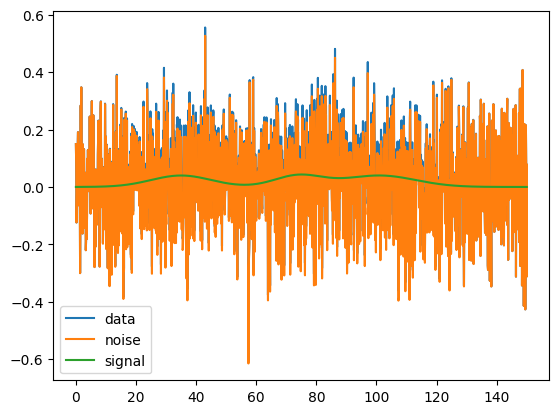

In [3]:
t = jnp.linspace(0, 150, 1501)
a = jnp.array([1, 0.8, 1.2])
m = jnp.array([35, 74, 101])
s = jnp.array([10, 8, 12])
sn = 0.15
snr = amplitude_to_snr(a, s, sn, t)

signal = signal_model(t, a, m, s)
noise = jax.random.normal(jax.random.key(0), t.shape) * sn
data = signal + noise

plt.plot(t, data, label = 'data')
plt.plot(t, noise, label = 'noise')
plt.plot(t, signal, label = 'signal')
plt.legend();

In [4]:
def sample(name, dist, *args, **kwargs):
    prior = numpyro.distributions.Normal()
    z = numpyro.sample(f'_{name}', prior, *args, **kwargs)
    return numpyro.deterministic(name, dist.icdf(prior.cdf(z)))

In [5]:
def order(x):
    k = x.size
    i = jnp.arange(k)
    y = jnp.power(1 - x, 1 / (k - i))
    y = jnp.cumprod(y)
    return y

## fixed dimension HMC

In [6]:
def model():
    with numpyro.plate('n', 3):
        # snr = numpyro.sample('snr', numpyro.distributions.Uniform(0, 10))
        # snr = sample('snr', numpyro.distributions.Uniform(0, 10))
        _snr = numpyro.sample('_snr', numpyro.distributions.Uniform())
        # _snr = sample('_snr', numpyro.distributions.Uniform())
        snr = numpyro.deterministic('snr', order(_snr) * 10)
        
        m = numpyro.sample('m', numpyro.distributions.Uniform(0, 150))
        # m = sample('m', numpyro.distributions.Uniform(0, 150))
        # _m = numpyro.sample('_m', numpyro.distributions.Uniform())
        # _m = sample('_m', numpyro.distributions.Uniform())
        # m = numpyro.deterministic('m', order(_m) * 150)
        
        s = numpyro.sample('s', numpyro.distributions.Uniform(5, 20))
        # s = sample('s', numpyro.distributions.Uniform(5, 20))

    a = numpyro.deterministic('a', snr_to_amplitude(snr, s, sn, t))
    signal = signal_model(t, a, m, s)
    noise = (data - signal) / sn
    with numpyro.plate('t', t.size):
        numpyro.sample('noise', numpyro.distributions.Normal(), obs = noise)

In [13]:
nuts = numpyro.infer.NUTS(model, dense_mass = False)
mcmc = numpyro.infer.MCMC(
    nuts, num_warmup = 1_000, num_samples = 1_000, num_chains = 1,
)
mcmc.run(jax.random.key(1))
mcmc.print_summary()

/tmp/ipykernel_2665340/2420860612.py:2: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|███████████████████████████| 2000/2000 [00:16<00:00, 124.59it/s, 31 steps of size 1.19e-01. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     _m[0]     -0.23      0.42     -0.50     -0.71      0.29      3.23      3.10
     _m[1]     -0.18      0.43      0.07     -0.73      0.34      3.25      2.87
     _m[2]      0.31      0.92      0.24     -1.06      2.05   1415.68      1.00
   _snr[0]      0.74      0.13      0.76      0.54      0.93     27.80      1.08
   _snr[1]      0.39      0.23      0.37      0.00      0.71     47.86      1.06
   _snr[2]      0.57      0.27      0.60      0.15      1.00    298.01      1.03
      s[0]     13.30      3.31     13.16      8.18     18.93    157.27      1.04
      s[1]     12.62      3.58     12.48      7.28     19.08    773.51      1.02
      s[2]     12.64      4.26     12.70      6.15     19.44   2431.37      1.00

Number of divergences: 0


In [14]:
snrs = mcmc.get_samples()['snr']
aa = mcmc.get_samples()['a']
mm = mcmc.get_samples()['m']
ss = mcmc.get_samples()['s']
samples = jnp.concatenate([snrs, mm, ss], axis = -1)
samples.shape

(5000, 9)

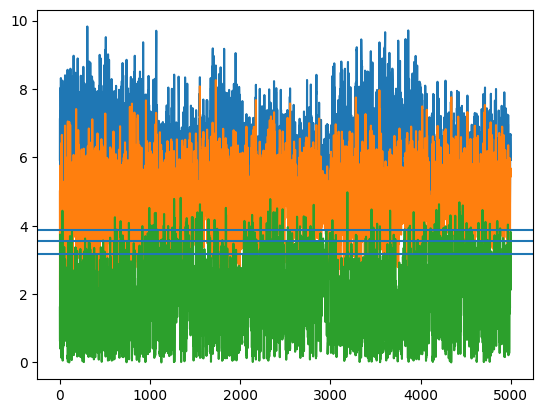

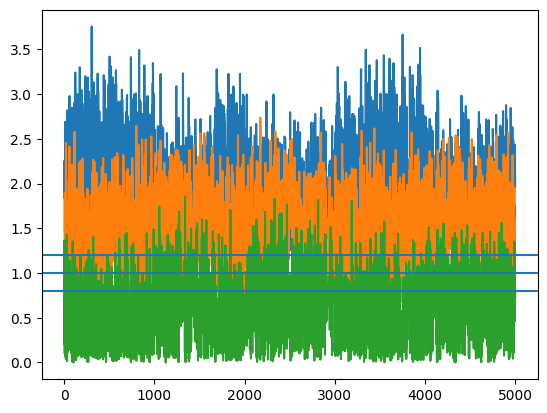

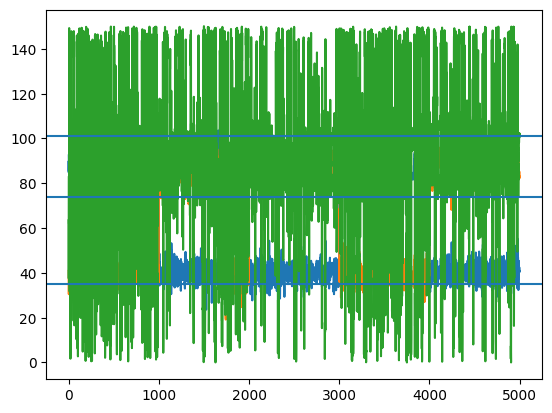

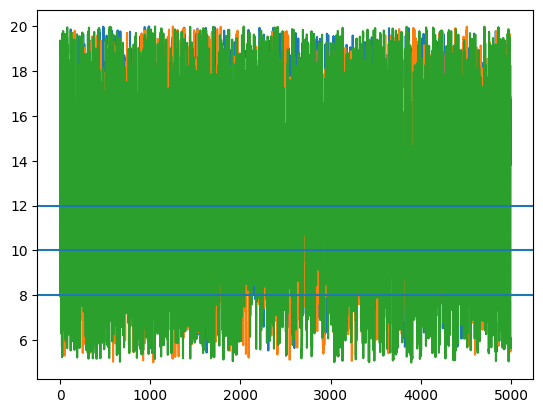

In [15]:
for chains, truths in zip((snrs, aa, mm, ss), (snr, a, m, s)):
    plt.plot(chains)
    for truth in truths:
        plt.axhline(truth)
    plt.show()

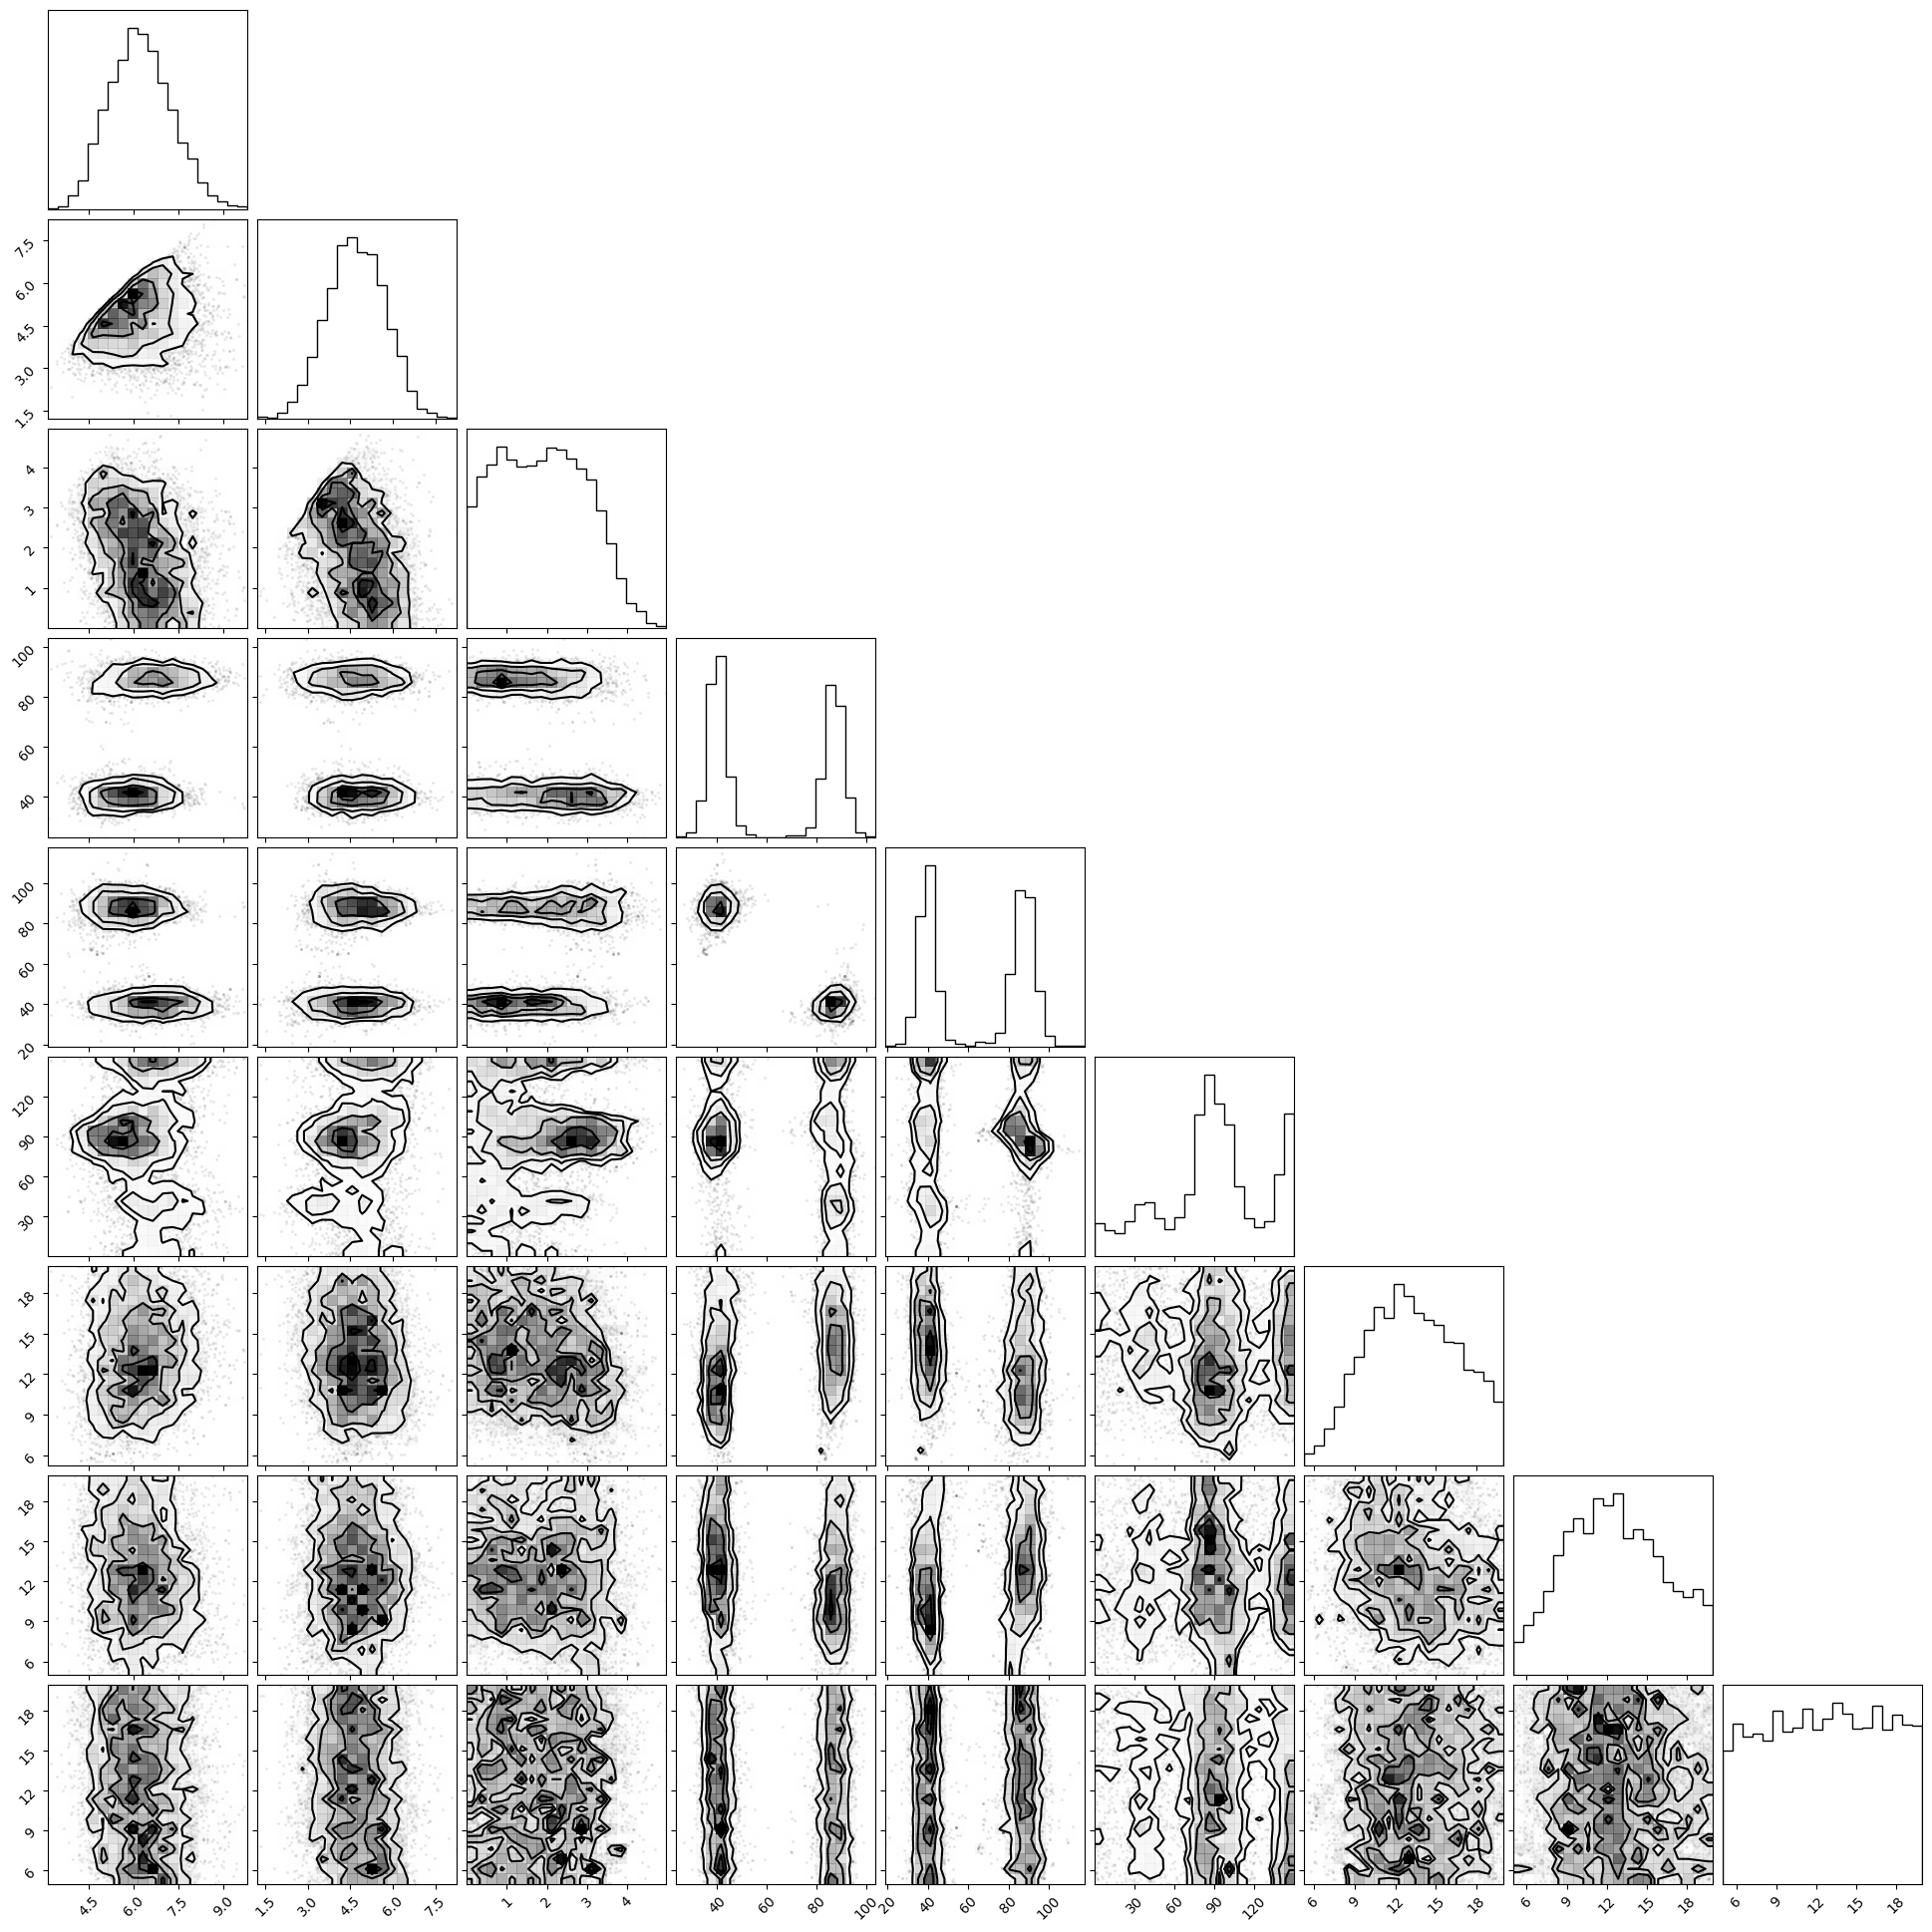

In [16]:
corner(np.array(samples));

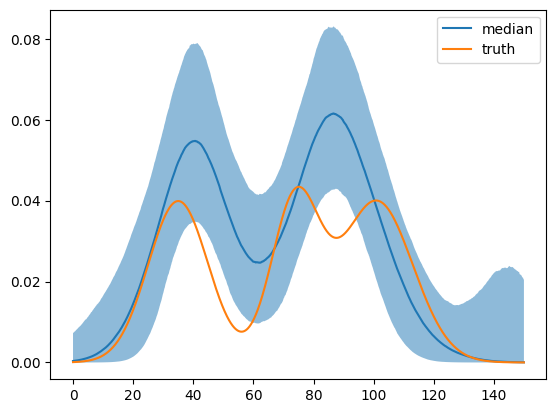

In [17]:
signals = signal_model(t[None, :], aa[:, None], mm[:, None], ss[:, None])
plt.fill_between(t, *np.quantile(signals, (0.05, 0.95), axis = 0), alpha = 0.5)
plt.plot(t, np.median(signals, axis = 0), label = 'median')
# plt.plot(t, data, label = 'data')
plt.plot(t, signal, label = 'truth')
plt.legend();

## transdimensional HMC

In [90]:
def model():
    n_max = 6

    with numpyro.plate('n_max', n_max):
        # snr = numpyro.sample('snr', numpyro.distributions.Uniform(0, 10))
        # snr = sample('snr', numpyro.distributions.Uniform(0, 10))
        _snr = numpyro.sample('_snr', numpyro.distributions.Uniform())
        # _snr = sample('_snr', numpyro.distributions.Uniform())
        snr = numpyro.deterministic('snr', order(_snr) * 10)
        
        m = numpyro.sample('m', numpyro.distributions.Uniform(0, 150))
        # m = sample('m', numpyro.distributions.Uniform(0, 150))
        # _m = numpyro.sample('_m', numpyro.distributions.Uniform())
        # _m = sample('_m', numpyro.distributions.Uniform())
        # m = numpyro.deterministic('m', order(_m) * 150)
        
        s = numpyro.sample('s', numpyro.distributions.Uniform(5, 20))
        # s = sample('s', numpyro.distributions.Uniform(5, 20))

    # there isn't a unique way to sample the number of parameters
    # the implementation can therefore be problem specific
    # here I sample it directly and mask the components with the lowest SNRs
    # the ordering transformation preserves uniformity within the allowed region
    # so the Jacobian is constant and we don't have to refactor it
    n = numpyro.sample(
        'n',
        numpyro.distributions.DiscreteUniform(
            1, n_max + 1, validate_args = True,
        ),
    )
    snr = jnp.where(jnp.arange(n_max) >= n, snr, 0)

    a = numpyro.deterministic('a', snr_to_amplitude(snr, s, sn, t))
    signal = signal_model(t, a, m, s)
    noise = (data - signal) / sn
    with numpyro.plate('t', t.size):
        numpyro.sample('noise', numpyro.distributions.Normal(), obs = noise)

In [102]:
nuts = numpyro.infer.NUTS(model, dense_mass = True)
gibbs = numpyro.infer.DiscreteHMCGibbs(
    nuts, random_walk = False, modified = False,
)
mcmc = numpyro.infer.MCMC(
    gibbs, num_warmup = 1_000, num_samples = 1_000, num_chains = 5,
)
mcmc.run(jax.random.key(2))
mcmc.print_summary()

/tmp/ipykernel_2665340/1470972091.py:5: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|████████████████████████████| 2000/2000 [00:43<00:00, 46.08it/s, 63 steps of size 1.01e-01. acc. prob=0.36]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   _snr[0]      0.53      0.30      0.55      0.09      0.99    137.49      1.04
   _snr[1]      0.54      0.27      0.56      0.14      0.98    197.47      1.02
   _snr[2]      0.51      0.27      0.53      0.08      0.91    543.11      1.01
   _snr[3]      0.47      0.27      0.47      0.01      0.85    133.77      1.03
   _snr[4]      0.48      0.29      0.47      0.00      0.89     79.86      1.05
   _snr[5]      0.50      0.28      0.52      0.04      0.93    484.04      1.02
      m[0]     75.49     43.19     75.60     12.43    145.43   2111.52      1.00
      m[1]     73.96     39.82     77.96      9.07    139.80    936.08      1.00
      m[2]     73.48     37.54     75.34     34.90    146.84      7.18      1.38
      m[3]     68.83     30.33     78.15     31.42    100.69     18.01      1.23
      m[4]     79.32     32.08     84.86     28.86    142.48    151.47      1.04
      m[5]     82.58     40

In [103]:
ns = mcmc.get_samples()['n']
snrs = mcmc.get_samples()['snr']
aa = mcmc.get_samples()['a']
mm = mcmc.get_samples()['m']
ss = mcmc.get_samples()['s']
samples = jnp.concatenate([snrs, mm, ss], axis = -1)
samples.shape

(5000, 18)

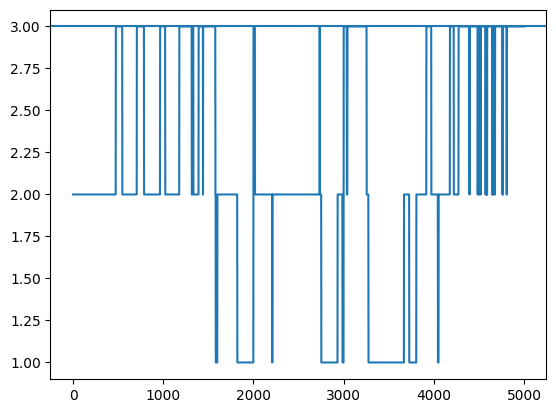

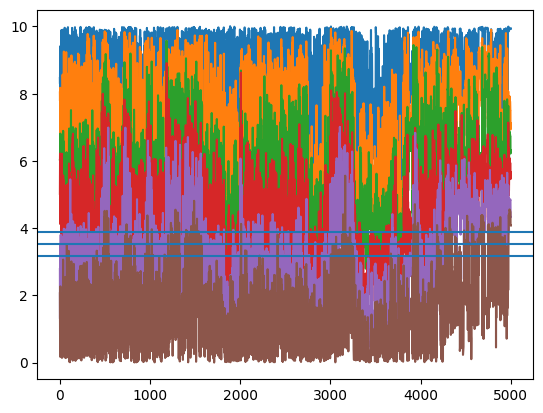

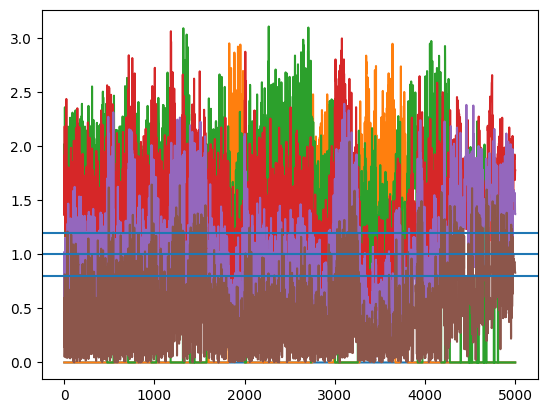

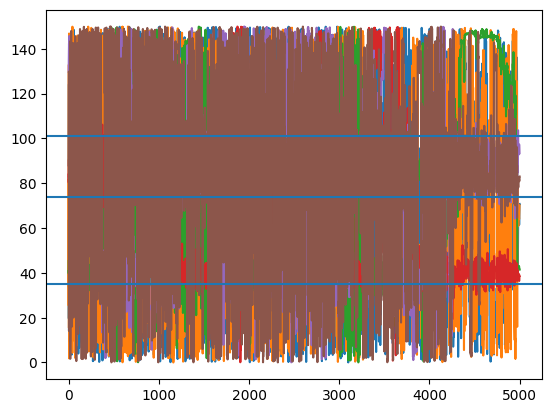

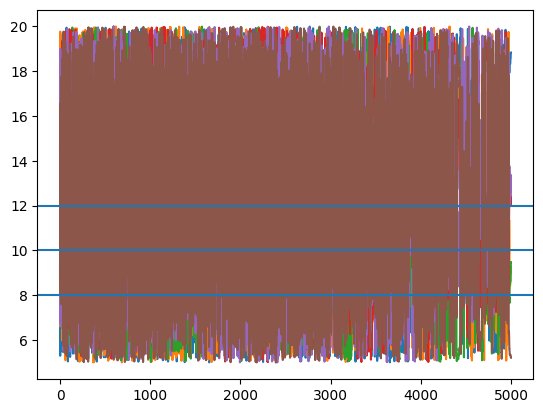

In [104]:
for chains, truths in zip((ns, snrs, aa, mm, ss), ([3], snr, a, m, s)):
    plt.plot(chains)
    for truth in truths:
        plt.axhline(truth)
    plt.show()

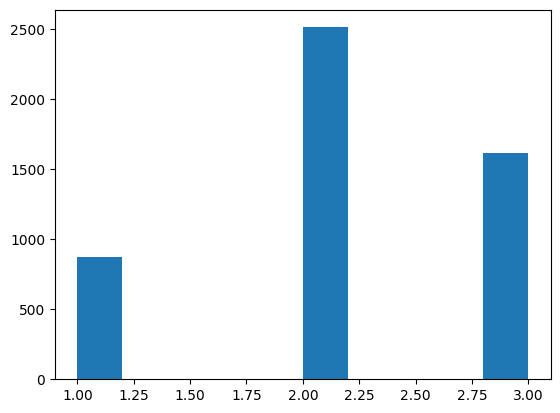

In [105]:
plt.hist(mcmc.get_samples()['n']);

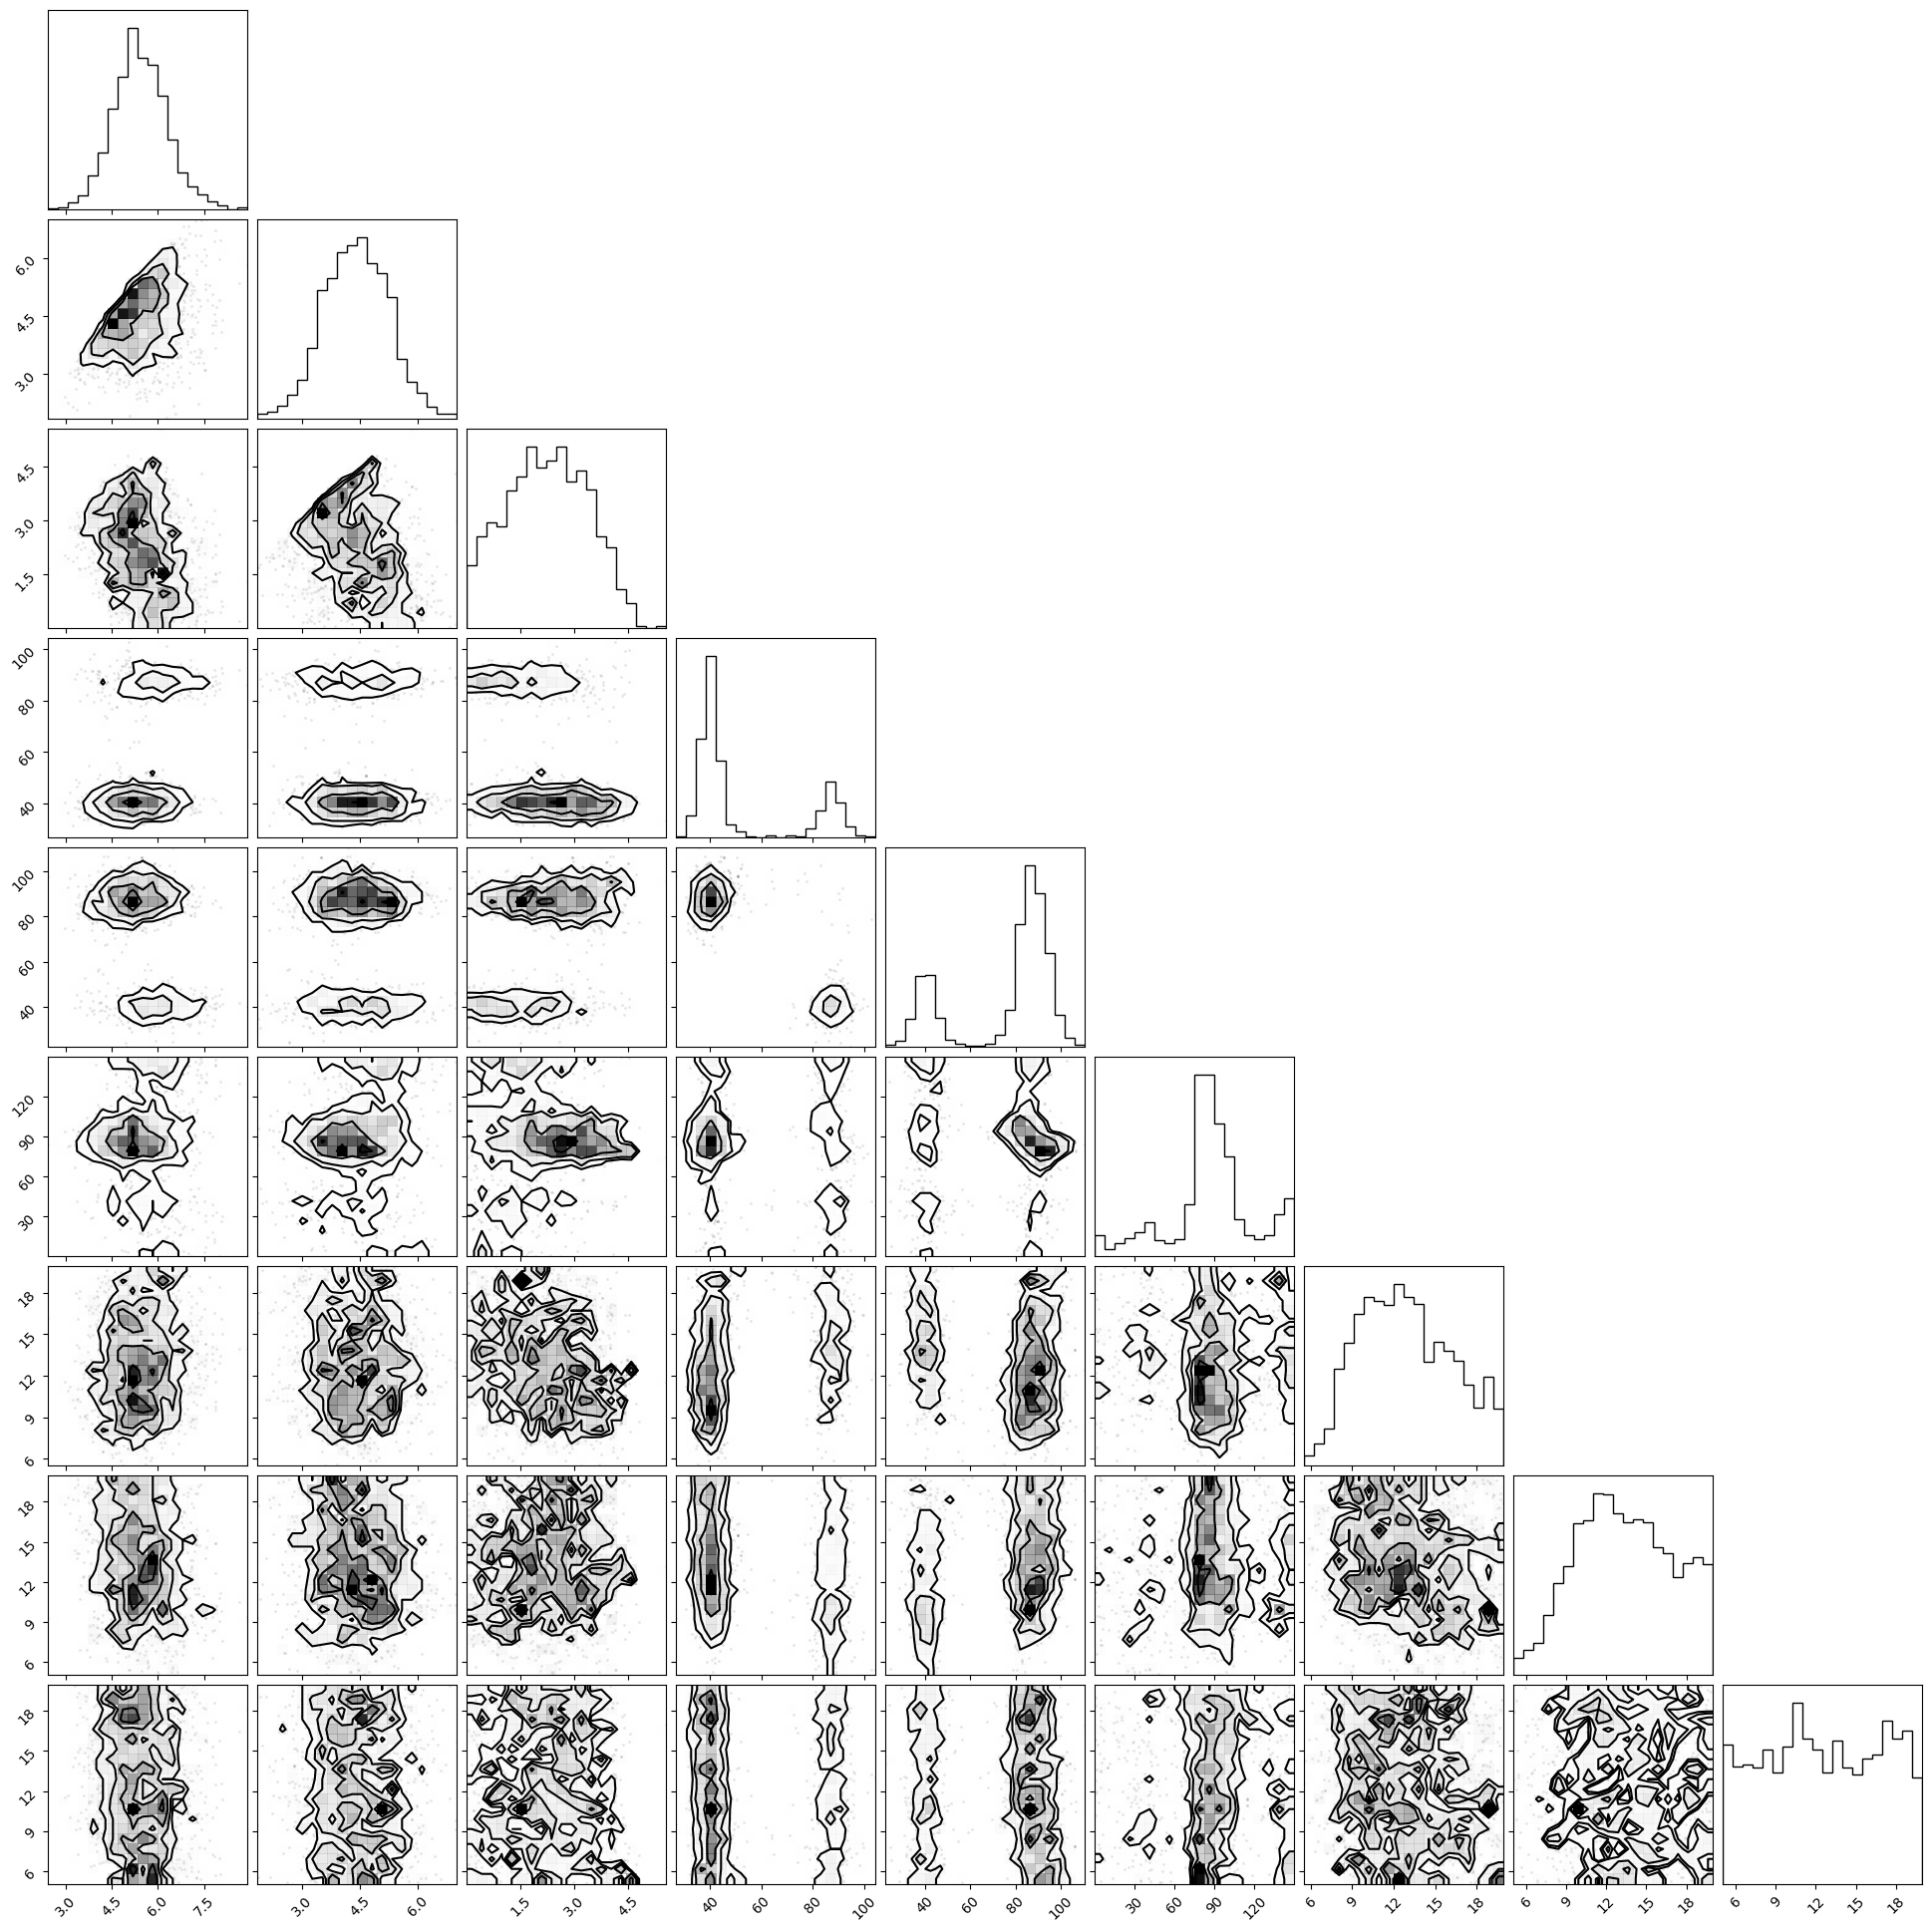

In [137]:
samples = jnp.stack([snrs, mm, ss])
samples = samples[:, ns == 3, :]
samples = samples[:, :, 3:]
samples = jnp.concatenate(samples, axis = -1)
corner(np.array(samples));

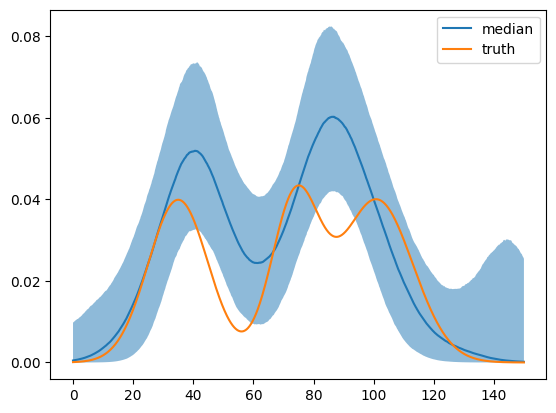

In [106]:
signals = signal_model(t[None, :], aa[:, None], mm[:, None], ss[:, None])
plt.fill_between(t, *np.quantile(signals, (0.05, 0.95), axis = 0), alpha = 0.5)
plt.plot(t, np.median(signals, axis = 0), label = 'median')
# plt.plot(t, data, label = 'data')
plt.plot(t, signal, label = 'truth')
plt.legend();